In [5]:
import torch
import numpy as np
import arviz as az
import pandas as pd

import sys
sys.path.append('../_mdofPINN/')
sys.path.append('../')

from pinnModels import mdof_stoch_pinn, gen_ndof_cantilever, nonlinearity

import seaborn as sns
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
sns.set_context('paper', font_scale=2.5, rc={'text.usetex' : True})

import matplotlib.pyplot as plt
import matplotlib
from IPython import display
%matplotlib inline
plt.rcParams.update({
    'text.usetex' : True,
    'mathtext.fontset' : 'stix',
    'font.family' : 'STIXGeneral'
})

%load_ext autoreload
%autoreload 2

def sort_data(vec2sort: torch.Tensor, *data_: tuple[torch.Tensor,...]):
    sort_ids = torch.argsort(vec2sort)
    sorted_data_ = [None] * len(data_)
    for i, data in enumerate(data_):
        sorted_data_[i] = torch.zeros_like(data)
        if len(data.shape) > 1:
            for j in range(data.shape[1]):
                sorted_data_[i][:,j] = data[sort_ids,j].squeeze()
        else:
            sorted_data_[i] = data[sort_ids]
    if len(data_) > 1:
        return tuple(sorted_data_), sort_ids
    else:
        return sorted_data_[0], sort_ids

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# filename = '20240820__sr_vandpd_2dof_fn_snr20'
filename = '20240829__sr_fullnln_2dof_fn_snr20'

checkpoint = torch.load(f'checkpoints/{filename}.pth')

pinn_config = checkpoint['pinn_config']
data_config = checkpoint['data_config']
ground_truth = checkpoint['ground_truth']
dataset = checkpoint['dataset']
mdof_model_dict = checkpoint['model']
train_loader = checkpoint['train_loader']
prediction = checkpoint['prediction']
alphas = checkpoint['alphas']
pinn_nonlinearity = checkpoint['pinn_nonlinearity']
n_dof = pinn_config['n_dof']
true_params = checkpoint['true_params']

mdof_model = mdof_stoch_pinn(pinn_config)
for net, state_dict in zip(mdof_model.nets, checkpoint['net_states']):
    net.load_state_dict(state_dict)
mdof_model.load_state_dict(mdof_model_dict)

match checkpoint['parser'].nonlin_type:
    case 'exponent_damping':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 0.5)
    case 'vanDerPol_damping':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = None, gc_exp = 'vdp')
    case 'duffing_stiffness':
        pinn_nonlinearity = nonlinearity(n_dof, gk_exp = 3, gc_exp = None)
mdof_model.set_aux_funcs(gen_ndof_cantilever, pinn_nonlinearity)

In [20]:
mcmc_model = torch.load(f'hmc_samples/{filename}_mcmc_model.pth')
hmc_samples = torch.load(f'hmc_samples/{filename}_hmc_samples.pth')
# alphas = torch.load(f'hmc_samples/{filename}_normed_2_alphas.pth')

###### VAN DER POL ########
# if filename[3:10] == 'vandpd_':
alphas.update({
        'k': torch.tensor([5.0]),
        'kn': torch.tensor([20.0]),
        'c': torch.tensor([0.5]),
        'cn': torch.tensor([0.5]),
        'sigma': torch.tensor([1.0e-1]),
        'm': torch.tensor([1.0])
    })
# elif filename[3:10] == 'fullnln':
#     alphas.update({
#         'k': torch.tensor([5.0]),
#         'kn': torch.tensor([50.0]),
#         'c': torch.tensor([0.5]),
#         'cn': torch.tensor([0.5]),
#         'sigma': torch.tensor([1.0e-1]),
#         'm': torch.tensor([1.0])
#     })

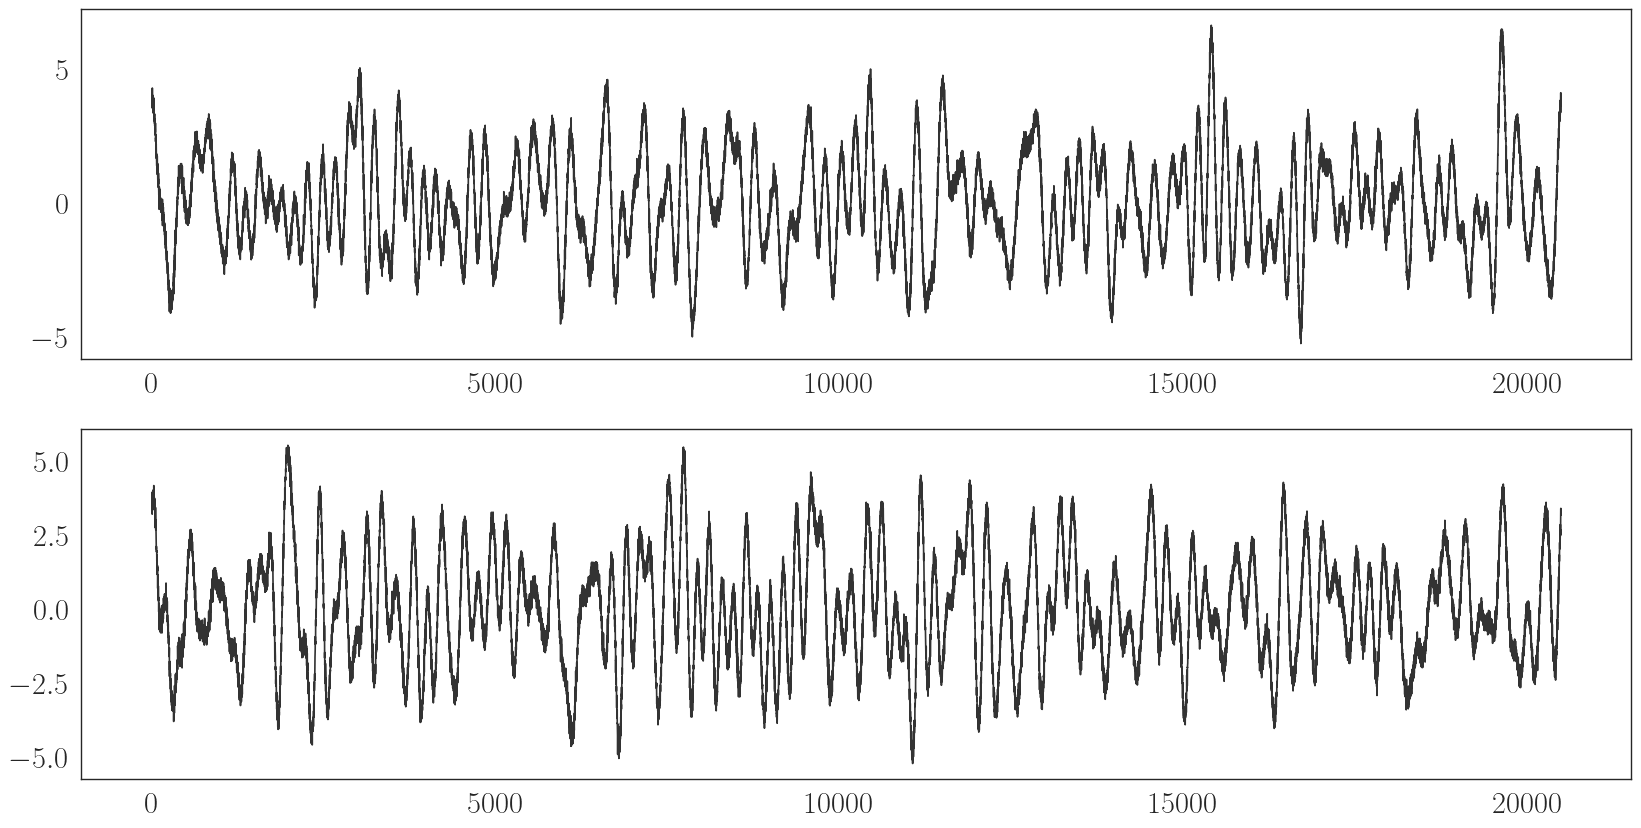

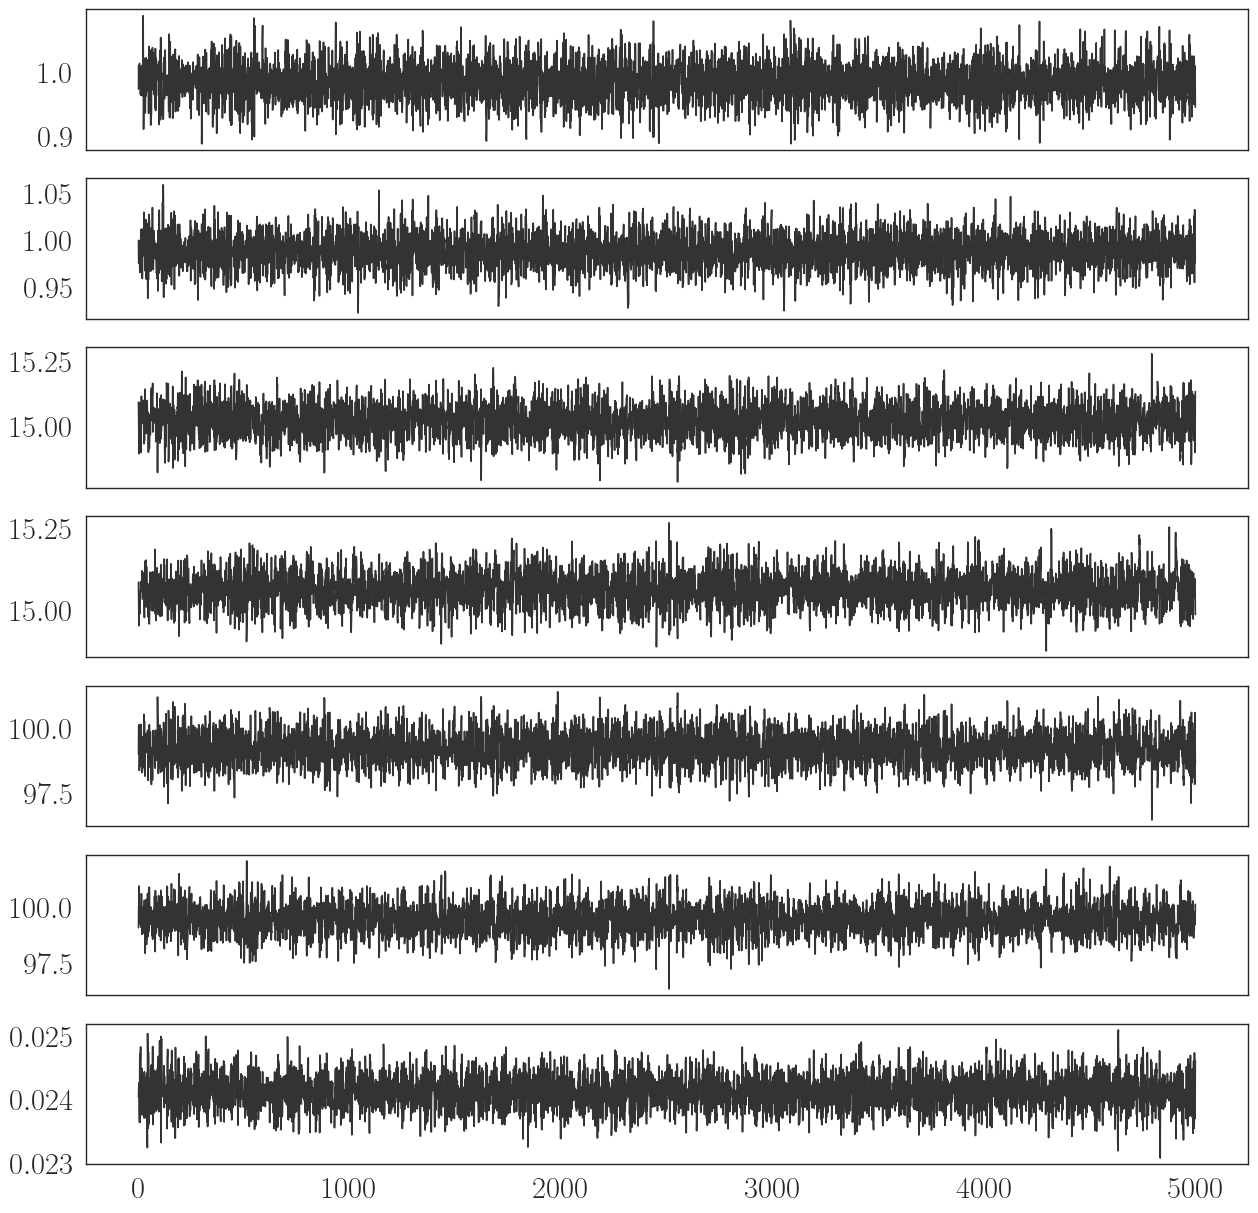

In [21]:
device = torch.device('cpu')
n_dof = pinn_config['n_dof']
n_repeats = 5

num_col_samps = prediction['t_hat'].shape[0]
t_pred = torch.zeros((num_col_samps * n_repeats, 1))
z_pred = torch.zeros((num_col_samps * n_repeats, 2*n_dof))
dzdt_pred = torch.zeros((num_col_samps * n_repeats, 2*n_dof))
f_col = torch.zeros((num_col_samps * n_repeats, n_dof))

# parse predicted data
col_step = data_config['batch_size'] * n_repeats * data_config['seq_len']

for i, (obs_data, _) in enumerate(train_loader):

    inpoint_ = i * col_step
    outpoint_ = (i + 1) * col_step
    t_col_ = [obs_data[:, :, nq, -1].reshape(-1, 1).requires_grad_() for nq in range(data_config['seq_len'])]
    force_obs_ = [obs_data[:, :, nq, 2*n_dof:-1].reshape(-1, n_dof).float().to(device) for nq in range(data_config['seq_len'])]
    z_pred_, _, t_pred_, dzdt_pred_, f_col_ = mdof_model.predict(t_col_, theta_s=None, f_col=force_obs_)

    t_pred[inpoint_:outpoint_] = t_pred_.reshape(-1,1)
    z_pred[inpoint_:outpoint_, :] = z_pred_.reshape(-1, 2*n_dof)
    dzdt_pred[inpoint_:outpoint_, :] = dzdt_pred_.reshape(-1, 2*n_dof)
    f_col[inpoint_:outpoint_, :] = f_col_.reshape(-1, n_dof)

(z_pred, f_col, t_pred, dzdt_pred), _ = sort_data(t_pred[:,0], z_pred, f_col, t_pred, dzdt_pred)

mdof_model.t_pred = t_pred
mdof_model.z_pred = z_pred
mdof_model.dzdt_pred = dzdt_pred
mdof_model.f_col = f_col

if filename[13:20] == 'vandpd_':
    labels = [f'c{i}' for i in range(n_dof)] + [f'k{i}' for i in range(n_dof)] + [f'cn{i}' for i in range(n_dof)] + ['sigma_f']
else:
    labels = [f'c{i}' for i in range(n_dof)] + [f'k{i}' for i in range(n_dof)] + [f'kn{i}' for i in range(n_dof)] + ['sigma_f']
xsamp = np.hstack( tuple(hmc_samples[label].reshape(-1,1) for label in labels) )

# num_draws_to_samp = xsamp.shape[0]//10
# for draw in range(num_draws_to_samp):
#     theta_s = torch.tensor(xsamp[draw*10,:], dtype=torch.float32)
#     log_likelihood = mcmc_model.log_likelihood(theta_s)

with sns.axes_style('white'):
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    for i in range(n_dof):
        # axs[i].plot(mdof_model.z_pred[:, i].detach(), color='k', alpha=0.8)
        # axs[i].plot(t_pred.detach() * alphas['t'].item(), mdof_model.z_pred[:, i].detach(), color='k', alpha=0.8)
        axs[i].plot(mdof_model.f_col[:, i].detach() * alphas['f'], color='k', alpha=0.8)
    # fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    # ax.plot(mcmc_model.log_likelihood)
    fig, axs = plt.subplots(3*n_dof+1, 1, figsize=(15, 15), sharex=True)
    for i in range(3*n_dof+1):
        axs[i].plot(xsamp[:,i], color='black', alpha=0.8)
    #     # axs[i].plot(autocorr(xsamp[:,i]), color='red', alpha=0.8)

# num_draws = xsamp.shape[0]//10
# force_draws = np.zeros((num_col_samps * n_repeats, num_draws, n_dof))
# for draw in range(num_draws):
#     theta_s = torch.tensor(xsamp[draw*10,:], dtype=torch.float32)
#     # print(theta_s)
#     force_draws[:, draw, :] = mdof_model.locked_force_pred(theta_s=theta_s).detach().numpy()

In [22]:
az_summ = az.summary(mcmc_model, hdi_prob=0.9)

# return statistics modes of posterior distributions
means_az = az_summ['mean']
# print(means)
stds_az = az_summ['sd']
if filename[13:20] == 'vandpd_':
    true_params_vec = [true_params['c_'][i] for i in range(n_dof)] + [true_params['cn_'][i] for i in range(n_dof)] + [true_params['k_'][i] for i in range(n_dof)] + [0.0]
else:
    true_params_vec = [true_params['c_'][i] for i in range(n_dof)] + [true_params['k_'][i] for i in range(n_dof)] + [true_params['kn_'][i] for i in range(n_dof)] + [0.0]

for i, (key, value) in enumerate(stds_az.items()):
    # if key == 'sigma_f[0]':
    if key == 'sigma_f':
        # print(f'{key}: {(means_az[key]*alphas[key[:-5]].item()):.4f} +/- {(value*alphas[key[:-5]].item()):.4f}')
        # error = np.abs(true_params_vec[i] - means_az[key] * alphas[key[:-5]].item())/true_params_vec[i] * 100
        print(f'{key}: {(means_az[key]):.4f} +/- {(value):.4f}')
        error = np.abs(true_params_vec[i] - means_az[key])/true_params_vec[i] * 100
    else:
        # print(f'{key}: {(means_az[key]*alphas[key[:-4]].item()):.4f} +/- {(value*alphas[key[:-4]].item()):.4f}')
        # error = np.abs(true_params_vec[i] - means_az[key] * alphas[key[:-4]].item())/true_params_vec[i] * 100
        print(f'{key}: {(means_az[key]):.4f} +/- {(value):.4f}')
        error = np.abs(true_params_vec[i] - means_az[key])/true_params_vec[i] * 100
    print(f'\t Error: {error:.4f}%  -  [{true_params_vec[i]:.4f}]')
    # print(f'{key}: {value:.4f}')

from sklearn.neighbors import KernelDensity
Xplot = np.zeros((100, 3*n_dof+1))
kdes = {}
pdfs = {}
means_np = np.zeros(3*n_dof+1)
stds_np = np.zeros(3*n_dof+1)
modes = np.zeros(3*n_dof+1)
kern_label = ['gaussian'] * 4 + ['gaussian'] * 2 + ['gaussian']
for i, label in enumerate(labels):
    kdes[label] = KernelDensity(bandwidth=0.1, kernel=kern_label[i]).fit(xsamp[:,i].reshape(-1,1))
    Xplot[:, i] = np.linspace(0, xsamp[:,i].max(), 100)
    pdfs[label] = kdes[label].score_samples(Xplot[:, i].reshape(-1,1))
    modes[i] = Xplot[np.argmax(pdfs[label]), i]
    means_np[i] = np.mean(xsamp[:,i])
    stds_np[i] = np.std(xsamp[:,i])
# print('\n')
# print(means_np)
# print(stds_np)
# print(modes)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


c0[0]: 0.9840 +/- 0.0300
	 Error: 1.6000%  -  [1.0000]
c1[0]: 0.9870 +/- 0.0190
	 Error: 1.3000%  -  [1.0000]
k0[0]: 15.0190 +/- 0.0650
	 Error: 0.1267%  -  [15.0000]
k1[0]: 15.0640 +/- 0.0530
	 Error: 0.4267%  -  [15.0000]
kn0[0]: 99.2140 +/- 0.6460
	 Error: 0.7860%  -  [100.0000]
kn1[0]: 99.4260 +/- 0.7010
	 Error: 0.5740%  -  [100.0000]
sigma_f[0]: 0.0240 +/- 0.0000
	 Error: inf%  -  [0.0000]


/var/folders/w8/_lnhm_b11w759xx3q8t1l9800000gn/T/ipykernel_76215/2921129151.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  error = np.abs(true_params_vec[i] - means_az[key])/true_params_vec[i] * 100


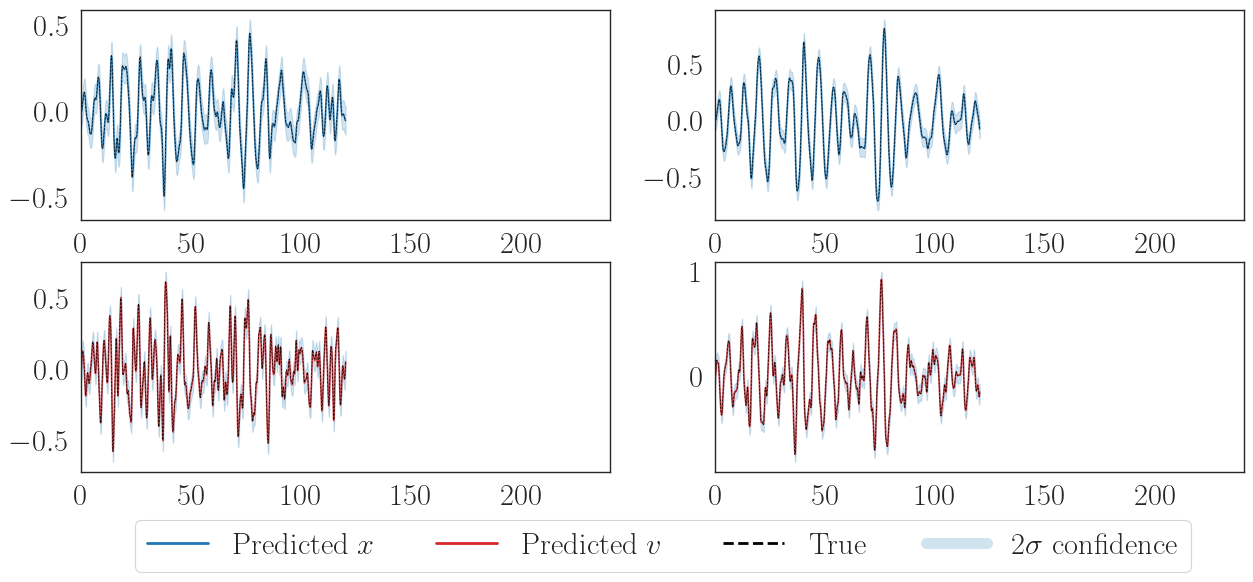

In [23]:
from matplotlib.lines import Line2D

with sns.axes_style('white'):
    fig, axs = plt.subplots(2, n_dof, figsize=(15, 6))
    for i in range(n_dof):
        axs[0, i].plot(t_pred.detach()*alphas['t'].item(), z_pred[:, i].detach()*alphas['x'].item(), 'tab:blue', alpha=0.8, label='Predicted')
        axs[0, i].plot(ground_truth['t'], ground_truth['x_hat'][:, i], 'black', label='True', linewidth=0.5, linestyle='--')
        axs[0, i].fill_between(t_pred[:,0].detach()*alphas['t'].item(), z_pred[:, i].detach()*alphas['x'].item() - 2*mdof_model.sigma_x.item()*alphas['x'].item(), z_pred[:, i].detach()*alphas['x'].item() + 2*mdof_model.sigma_x.item()*alphas['x'].item(), color='tab:blue', alpha=0.2, label='$2\sigma$ confidence')
        axs[0, i].set_xlim((0,240))

        axs[1, i].plot(t_pred.detach()*alphas['t'].item(), z_pred[:, i+n_dof].detach()*alphas['v'].item(), 'tab:red', alpha=0.8, label='Predicted')
        axs[1, i].plot(ground_truth['t'], ground_truth['v_hat'][:, i], 'black', label='True', linewidth=0.5, linestyle='--')
        axs[1, i].fill_between(t_pred[:,0].detach()*alphas['t'].item(), z_pred[:, i+n_dof].detach()*alphas['v'].item() - 2*mdof_model.sigma_v.item()*alphas['v'].item(), z_pred[:, i+n_dof].detach()*alphas['v'].item() + 2*mdof_model.sigma_v.item()*alphas['v'].item(), color='tab:blue', alpha=0.2, label='$2\sigma$ confidence')
        axs[1, i].set_xlim((0,240))

    custom_lines = [Line2D([0], [0], color='tab:blue', lw=2.0),
                    Line2D([0], [0], color='tab:red', lw=2.0),
                    Line2D([0], [0], color='black', linestyle='--', lw=2.0),
                    Line2D([0], [0], color='tab:blue', alpha=0.2, lw=8.0)]
    
    # leg = axs[-1, 0].legend(fontsize=36, loc='upper center', bbox_to_anchor=(1.1, -0.55), ncol=3)
    leg = axs[1, 1].legend(custom_lines, ['Predicted $x$', 'Predicted $v$', 'True', '$2\sigma$ confidence'], loc='lower center', bbox_to_anchor=(-0.1, -0.55), ncol=4)

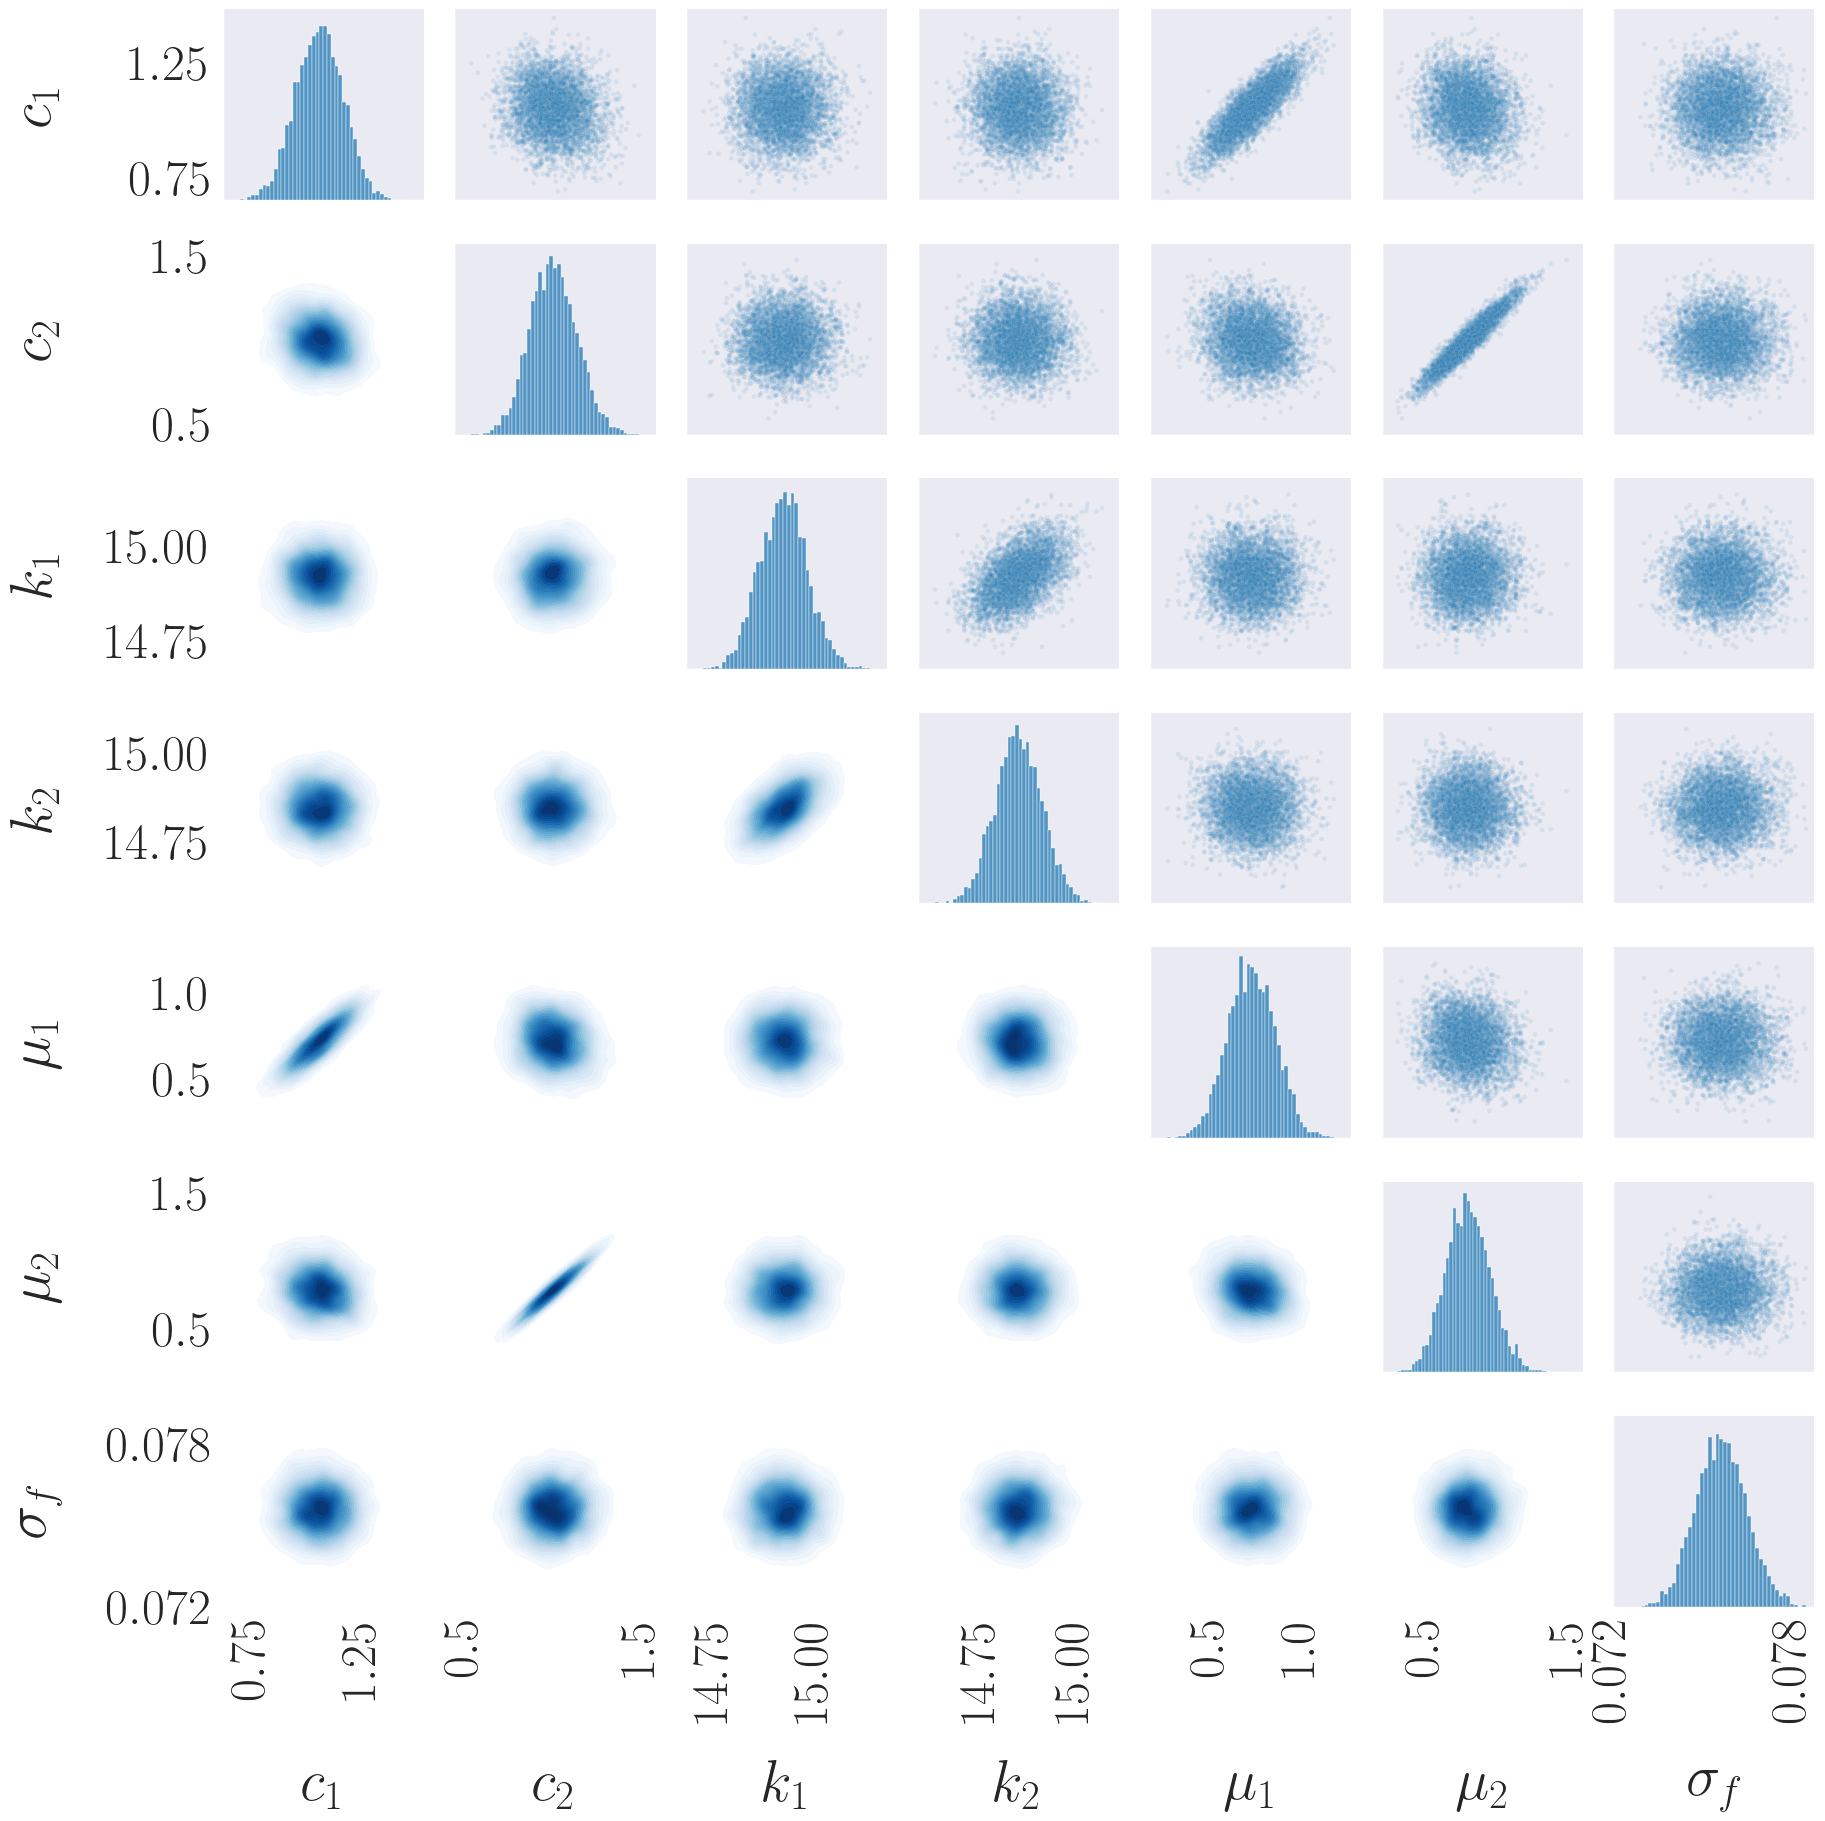

In [7]:
alpha_vec = np.array([alphas[label[:-1]].item() for label in labels[:-1]] + [alphas['sigma'].item()])

if filename[13:20] == 'vandpd_':
    ### Van Der Pol ###
    ticks__ = [[0.75, 1.25], [0.5, 1.5]] + [[14.75, 15.0]] * 2 + [[0.5, 1.0], [0.5, 1.5]] + [[0.072, 0.078]]
    true_params_vec = np.concatenate((true_params['c_'], true_params['cn_'], true_params['k_'], np.array([1e-3])))
    labels_plot = [f'$c_{i+1}$' for i in range(n_dof)] + [f'$k_{i+1}$' for i in range(n_dof)] + [f'$\mu_{i+1}$' for i in range(n_dof)] + ['$\sigma_f$']
else:
    ### Duffing ###
    ticks__ = [[0.95, 1.05]] * 2 + [[14.75, 15.25]] * 2 + [[97.5, 102.5]] * 2 + [[0.023, 0.025]]
    true_params_vec = np.concatenate((true_params['c_'], true_params['k_'], true_params['kn_'], np.array([1e-3])))
    labels_plot = [f'$c_{i+1}$' for i in range(n_dof)] + [f'$k_{i+1}$' for i in range(n_dof)] + [f'$\kappa_{i+1}$' for i in range(n_dof)] + ['$\sigma_f$']

# xsamp = xsamp * alpha_vec
xsamp_df = pd.DataFrame(xsamp[:,:], columns=labels_plot)

sns.set_style(
    style='dark',
    rc = {
    'figure.figsize':(40,40),
    'font.fontsize' : 36
    })

sns_grid = sns.PairGrid(xsamp_df)
sns_grid.map_diag(sns.histplot, stat='probability')
sns_grid.map_upper(sns.scatterplot, size=5, alpha=0.1)
sns_grid.map_lower(sns.kdeplot, fill=True, cmap="Blues", levels=25)

# sns_grid.axes[2,0].set_facecolor('white')
for i in range(sns_grid.axes.shape[0]):
    sns_grid.axes[i, 0].set_ylabel(labels_plot[i], fontsize=42)
    sns_grid.axes[i, 0].set_yticks(ticks__[i])
    sns_grid.axes[i, 0].tick_params(axis='y', labelsize=36)
    sns_grid.axes[-1, i].set_xlabel(labels_plot[i], fontsize=42)
    # sns_grid.axes[-1, i].set_xticks([])
    sns_grid.axes[-1, i].set_xticks(ticks__[i])
    sns_grid.axes[-1, i].tick_params(axis='x', labelsize=36, rotation=90)
    for j in range(sns_grid.axes.shape[0]):
        # sns_grid.axes[i,j].axvline(true_params_vec[j], color='r', linestyle='--')
        # sns_grid.axes[i,j].axhline(true_params_vec[i], color='r', linestyle='--')
        if i > j:
            sns_grid.axes[i, j].set_facecolor('white')
    
    # if i < sns_grid.axes.shape[0]-1:
    #     sns_grid.axes[i, i].axvline(true_params_vec[i], color='r', linestyle='--')


sns.despine(sns_grid.figure)
for ax in sns_grid.axes.flatten():
    ax.title.set_position([.5, 1.1])
    ax.yaxis.labelpad = 15

for ax in sns_grid.axes[:,0]:
    ax.get_yaxis().set_label_coords(-0.8,0.5)
    
for ax in sns_grid.axes[-1,:]:
    ax.get_xaxis().set_label_coords(0.5,-0.8)

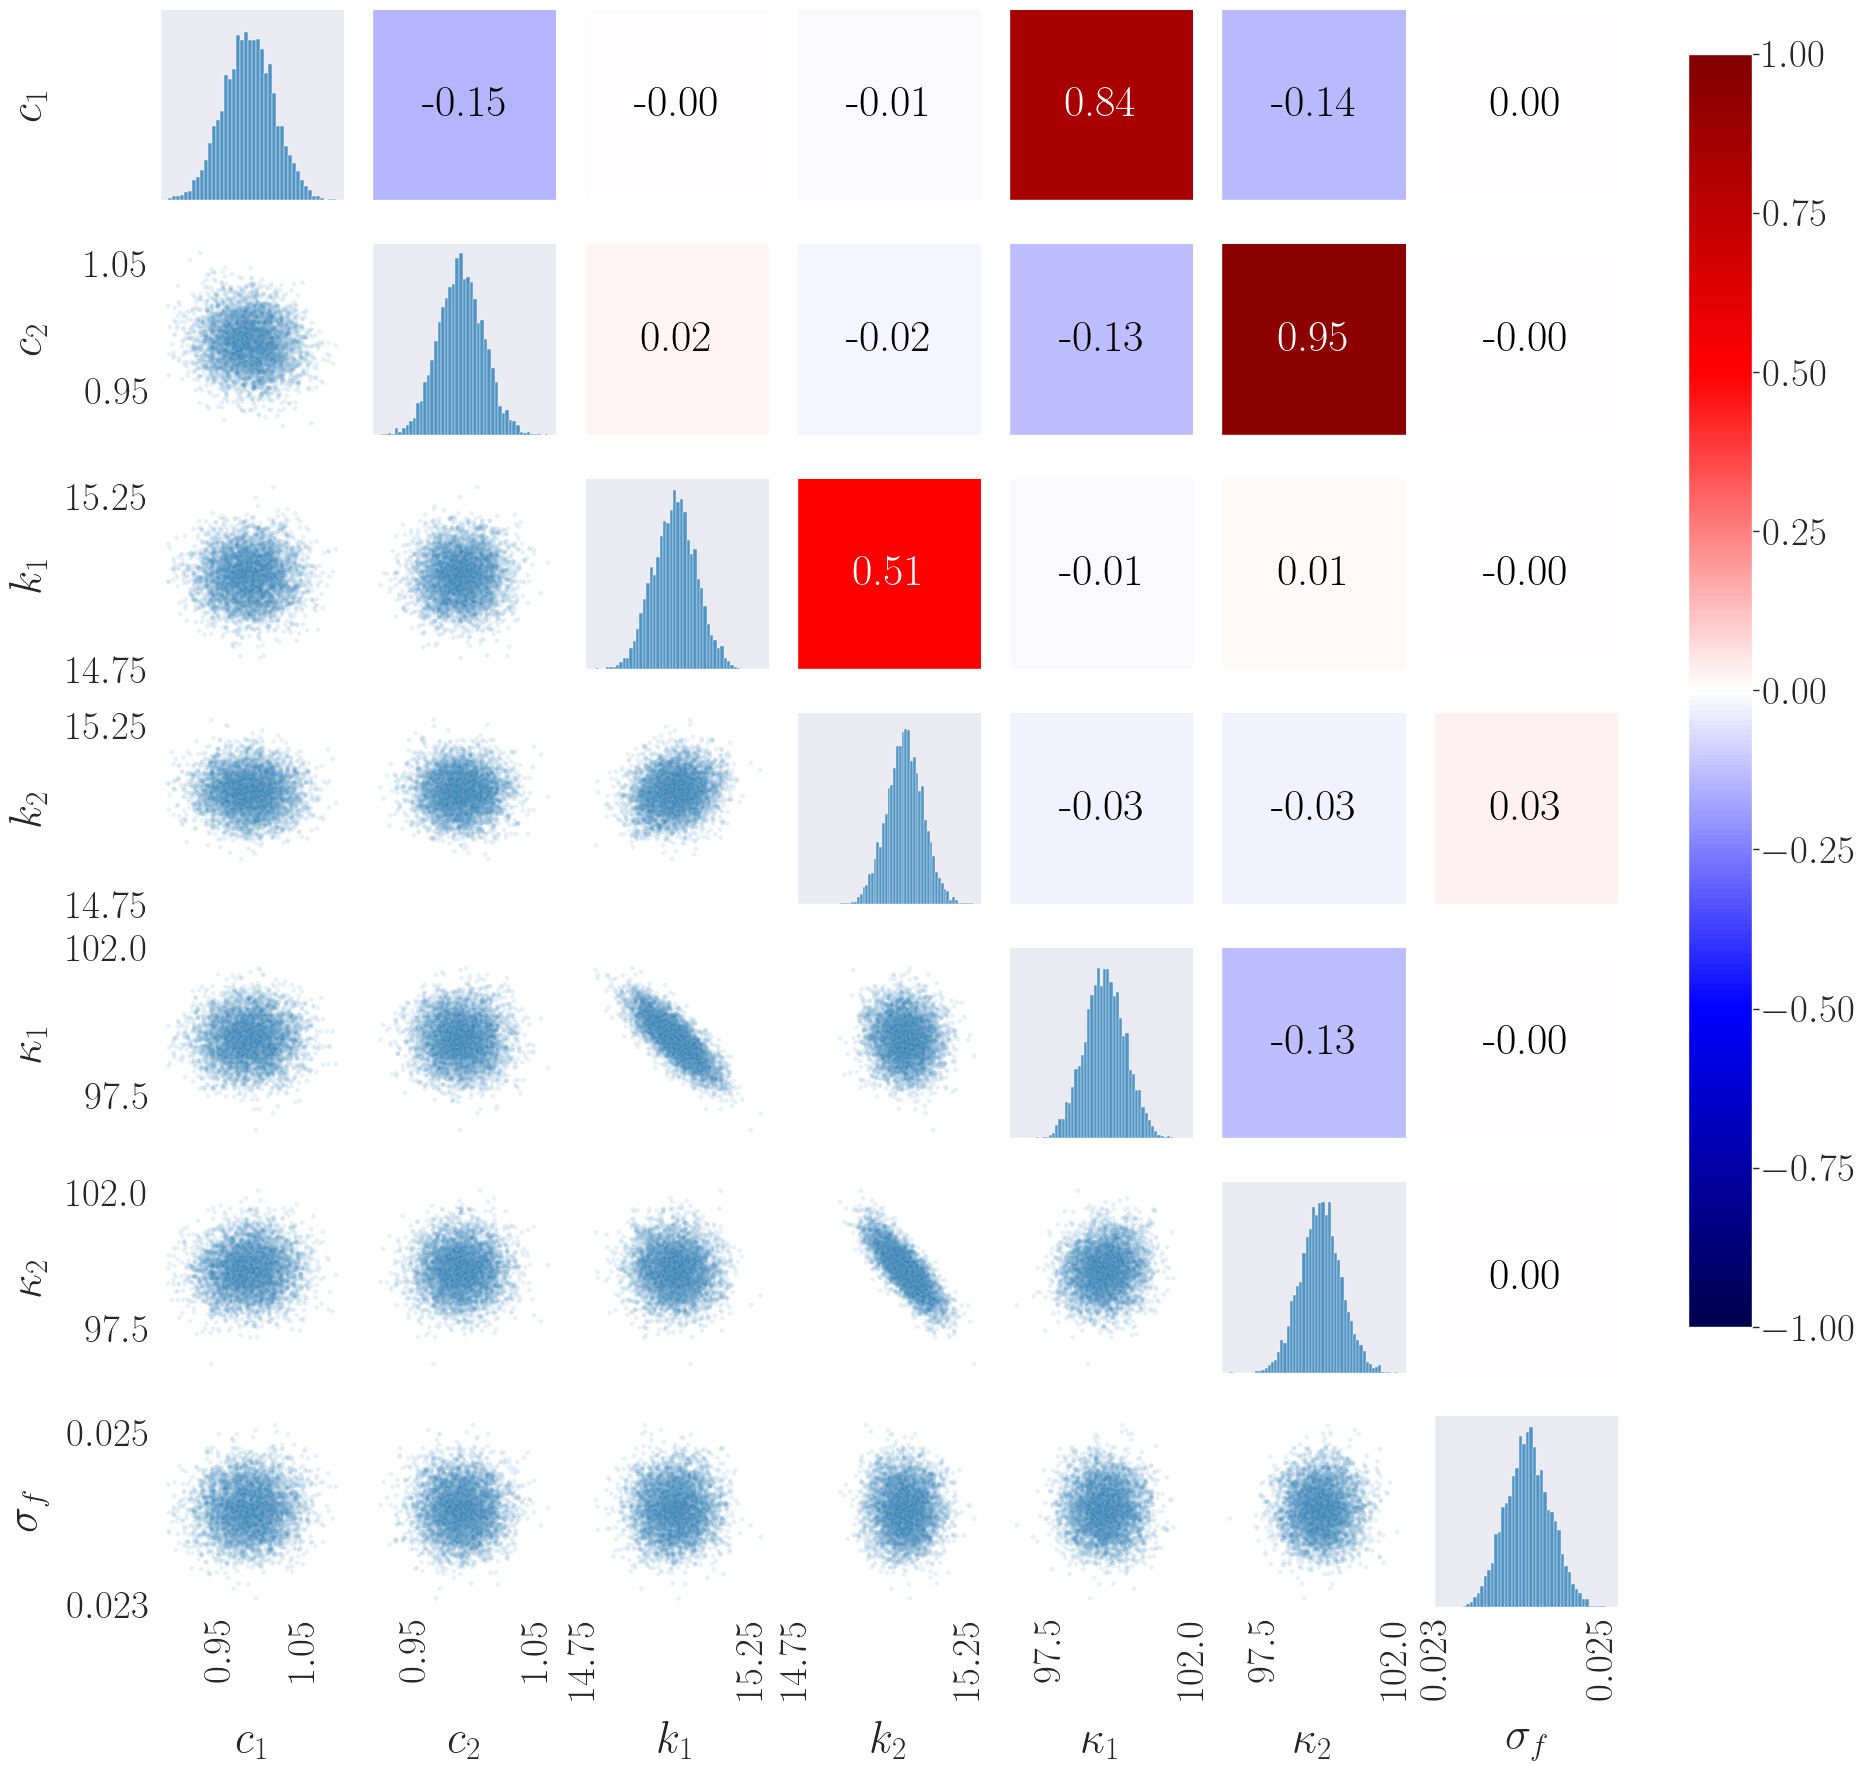

In [24]:
df_corr = xsamp_df.corr()

alpha_vec = np.array([alphas[label[:-1]].item() for label in labels[:-1]] + [alphas['sigma'].item()])

if filename[13:20] == 'vandpd_':
    ### Van Der Pol ###
    ticks__ = [[0.75, 1.25], [0.5, 1.5]] + [[14.75, 15.0]] * 2 + [[0.5, 1.0], [0.5, 1.5]] + [[0.072, 0.078]]
    true_params_vec = np.concatenate((true_params['c_'], true_params['k_'], true_params['cn_'], np.array([1e-3])))
    labels_plot = [f'$c_{i+1}$' for i in range(n_dof)] + [f'$k_{i+1}$' for i in range(n_dof)] + [f'$\mu_{i+1}$' for i in range(n_dof)] + ['$\sigma_f$']
else:
    ### Duffing ###
    ticks__ = [[0.95, 1.05]] * 2 + [[14.75, 15.25]] * 2 + [[97.5, 102]] * 2 + [[0.023, 0.025]]
    true_params_vec = np.concatenate((true_params['c_'], true_params['k_'], true_params['kn_'], np.array([1e-3])))
    labels_plot = [f'$c_{i+1}$' for i in range(n_dof)] + [f'$k_{i+1}$' for i in range(n_dof)] + [f'$\kappa_{i+1}$' for i in range(n_dof)] + ['$\sigma_f$']

# xsamp = xsamp * alpha_vec
xsamp_df = pd.DataFrame(xsamp[:,:], columns=labels_plot)

sns.set_style(
    style='dark',
    rc = {
    'figure.figsize':(40,45),
    'font.fontsize' : 32
    })

# Enable LaTeX rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')  # Optional: set a specific font family if needed

# cmap = matplotlib.cm.get_cmap('seismic')
cmap = matplotlib.colormaps['seismic']
norm = plt.Normalize(-1, 1)

sns_grid = sns.PairGrid(xsamp_df)
sns_grid.map_diag(sns.histplot, stat='probability')
sns_grid.map_lower(sns.scatterplot, size=5, alpha=0.1)

big_font_size = 32
small_font_size = 28

# sns_grid.axes[2,0].set_facecolor('white')
for i in range(sns_grid.axes.shape[0]):
    sns_grid.axes[i, 0].set_ylabel(labels_plot[i], fontsize=big_font_size)
    sns_grid.axes[i, 0].set_yticks(ticks__[i])
    sns_grid.axes[i, 0].tick_params(axis='y', labelsize=small_font_size)
    sns_grid.axes[-1, i].set_xlabel(labels_plot[i], fontsize=big_font_size)
    # sns_grid.axes[-1, i].set_xticks([])
    sns_grid.axes[-1, i].set_xticks(ticks__[i])
    sns_grid.axes[-1, i].tick_params(axis='x', labelsize=small_font_size, rotation=90)
    for j in range(sns_grid.axes.shape[0]):
        # sns_grid.axes[i,j].axvline(true_params_vec[j], color='r', linestyle='--')
        # sns_grid.axes[i,j].axhline(true_params_vec[i], color='r', linestyle='--')
        if i > j:
            sns_grid.axes[i, j].set_facecolor('white')
        elif i < j:
            # Plot the correlation values
            corr_value = df_corr.iloc[i, j]
            centre_y = sns_grid.axes[j, i].get_ylim()[0] + (sns_grid.axes[j, i].get_ylim()[1] - sns_grid.axes[j, i].get_ylim()[0]) / 2
            centre_x = sns_grid.axes[j, i].get_xlim()[0] + (sns_grid.axes[j, i].get_xlim()[1] - sns_grid.axes[j, i].get_xlim()[0]) / 2
            sns_grid.axes[i, j].annotate(f'{corr_value:.2f}',
                    xy = (0.5, 0.5), xycoords='axes fraction',  # Use axis fraction for coordinates
                    ha='center', va='center', 
                    fontsize=big_font_size, color='black' if np.abs(corr_value) < 0.5 else 'white')
            
            sns_grid.axes[i, j].set_facecolor(cmap(norm(corr_value)))
    
    # if i < sns_grid.axes.shape[0]-1:
    #     sns_grid.axes[i, i].axvline(true_params_vec[i], color='r', linestyle='--')

sns_grid.axes[0, 0].set_yticks([])

sns.despine(sns_grid.figure)
for ax in sns_grid.axes.flatten():
    ax.title.set_position([.5, 1.1])
    ax.yaxis.labelpad = 15

for ax in sns_grid.axes[:,0]:
    ax.get_yaxis().set_label_coords(-0.6,0.5)
    
for ax in sns_grid.axes[-1,:]:
    ax.get_xaxis().set_label_coords(0.5,-0.6)

# Add a colorbar manually
# Create a new figure for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1))
cbar = plt.colorbar(sm, ax=sns_grid.figure.axes, orientation='vertical', fraction=0.04, pad=0.15)
cbar.ax.set_anchor((0.5, 0.865))
cbar.ax.tick_params(labelsize=small_font_size) 

# Adjust the layout
plt.subplots_adjust(right=0.9)  # Adjust right to make space for colorbar

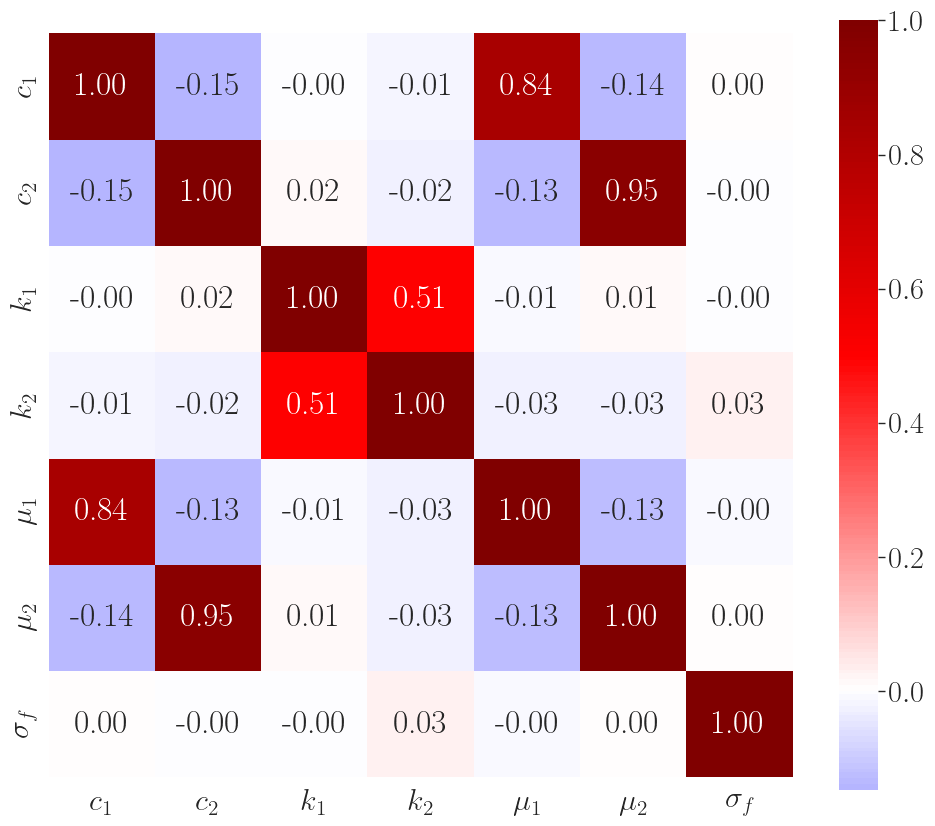

In [9]:
sample_covariance = np.cov(xsamp, rowvar=False)
prior_covariance = np.eye(xsamp.shape[1])
posterior_covariance = np.linalg.inv(np.linalg.inv(prior_covariance) + xsamp.shape[0] * np.linalg.inv(sample_covariance))

posterior_corr = np.corrcoef(xsamp, rowvar=False)

cov_df = pd.DataFrame(posterior_covariance, columns=labels_plot, index=labels_plot)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns_hmp = sns.heatmap(
    posterior_corr, 
    ax=ax, 
    cmap='seismic', 
    center=0,
    xticklabels=labels_plot, 
    yticklabels=labels_plot, 
    square=True, 
    annot=True, 
    fmt=".2f")

In [ ]:
sns_grid.savefig(f'figs/{filename[10:]}.png', bbox_inches='tight')
sns_grid.savefig(f'figs/{filename[10:]}.eps', bbox_inches='tight', dpi=72)
sns_hmp.figure.savefig(f'figs/{filename[10:]}_corr.png', bbox_inches='tight')
sns_hmp.figure.savefig(f'figs/{filename[10:]}_corr.eps', bbox_inches='tight', dpi=72)